### **1. Setup & Library Imports**

In [3]:
import torch
import random
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

seed = 43
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda")

### **2. Config hyperparameters**

In [4]:
batch_size = 512
latent_dim = 128
text_embedding_dim = 10
diffusion_steps = 1000
beta_start = 0.0001
beta_end = 0.01
image_size = 28

### **3. Dataset Preparation**

In [5]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),

    ]
)


train_dataset = datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
)


test_dataset = datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)

test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=2
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 15.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 2.40MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 11.9MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.53MB/s]


## **4. Stable Diffusion**

### **4.1 DDPM**

In [6]:
class DiffusionModel:
    def __init__(
        self, num_steps=diffusion_steps, beta_start=beta_start, beta_end=beta_end
    ):
        self.num_steps = num_steps
        self.betas = torch.linspace(beta_start, beta_end, num_steps).to(device)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - self.alphas_cumprod)

    def forward_diffusion(self, x0, t):
        epsilon = torch.randn_like(x0)

        sqrt_alphas_cumprod_t = self.sqrt_alphas_cumprod[t].view(-1, 1)
        sqrt_one_minus_alphas_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t].view(
            -1, 1
        )

        noisy_x = sqrt_alphas_cumprod_t * x0 + sqrt_one_minus_alphas_cumprod_t * epsilon
        return noisy_x, epsilon

    def sample_timesteps(self, batch_size):
        return torch.randint(0, self.num_steps, (batch_size,), device=device)

In [7]:
def visualize_noise_addition(image, label, noise_scheduler, num_steps=9):
    image = image.to(device)
    timesteps = (
        torch.linspace(0, noise_scheduler.num_steps - 1, num_steps + 1)
        .long()
        .to(device)
    )

    fig, axes = plt.subplots(1, num_steps + 1, figsize=((num_steps + 1) * 2, 6))

    axes[0].imshow(image.cpu().squeeze().numpy(), cmap="gray")
    axes[0].set_title(f"Original\nLabel: {label}")
    axes[0].axis("off")

    for i, t in enumerate(timesteps[1:]):
        noisy_image, _ = noise_scheduler.forward_diffusion(image, t)
        axes[i + 1].imshow(noisy_image.cpu().squeeze().numpy(), cmap="gray")
        axes[i + 1].set_title(f"t={t.item()}/{noise_scheduler.num_steps - 1}")
        axes[i + 1].axis("off")

    plt.tight_layout()
    plt.show()

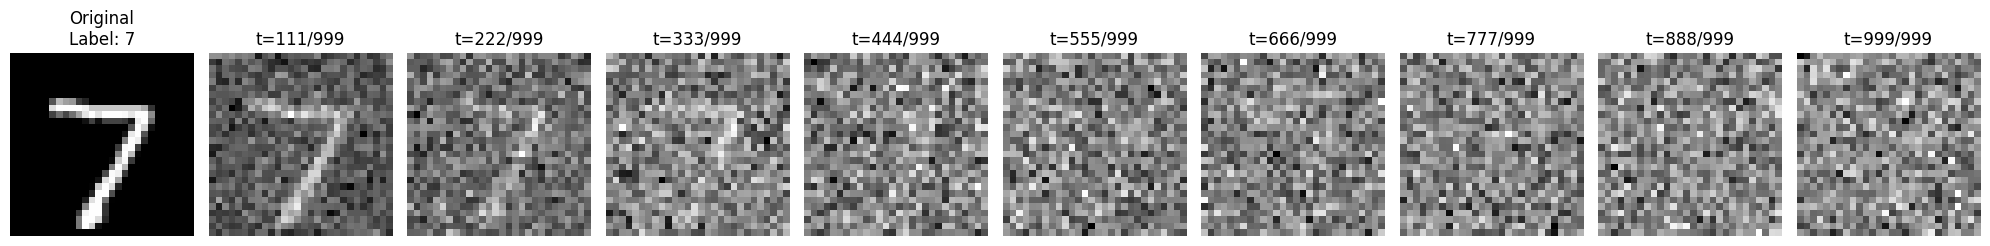

In [8]:
noise_scheduler = DiffusionModel(
    num_steps=diffusion_steps, beta_start=beta_start, beta_end=beta_end
)


images, labels = next(iter(test_loader))

image, label = images[0], labels[0].item()


visualize_noise_addition(image, label, noise_scheduler, num_steps=9)

### **4.2 VAE**

In [9]:
class VAEEncoder(nn.Module):
    def __init__(self, latent_dim):
        super(VAEEncoder, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def encode(self, x):
        mu, logvar = self.forward(x)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z


class VAEDecoder(nn.Module):
    def __init__(self, latent_dim):
        super(VAEDecoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 28 * 28)

    def forward(self, z):
        x = F.relu(self.fc1(z))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        x = x.view(-1, 1, 28, 28)
        return x

### **4.3 Onehot Text Encoder**

In [10]:
class TextEmbedding(nn.Module):
    def __init__(self, num_classes=10):
        super(TextEmbedding, self).__init__()
        self.num_classes = num_classes

    def forward(self, digit_label):
        one_hot = F.one_hot(digit_label, num_classes=self.num_classes).float()
        return one_hot

### **4.4 UNet**

In [11]:
class UNet(nn.Module):
    def __init__(self, latent_dim, text_embedding_dim):
        super(UNet, self).__init__()
        # Combined latent + timestep + text embedding
        combined_dim = latent_dim + 1 + text_embedding_dim

        # Encoder part
        self.enc1 = nn.Linear(latent_dim, 256)
        self.enc2 = nn.Linear(256, 512)

        # Middle part with conditioning
        self.mid1 = nn.Linear(512 + 1 + text_embedding_dim, 512)
        self.mid2 = nn.Linear(512, 512)

        # Decoder part
        self.dec1 = nn.Linear(512 + 512, 256)  # Skip connection from enc2
        self.dec2 = nn.Linear(256 + 256, latent_dim)  # Skip connection from enc1

    def forward(self, x, t, text_emb):
        # x: [batch_size, latent_dim]
        # t: [batch_size, 1] - timestep
        # text_emb: [batch_size, text_embedding_dim]

        # Encoder
        e1 = F.relu(self.enc1(x))
        e2 = F.relu(self.enc2(e1))

        # Middle with condition
        t_emb = t.repeat(1, 1)  # Ensure t is [batch_size, 1]
        text_emb_expanded = text_emb  # [batch_size, text_embedding_dim]

        # Concatenate in the following order: latent, time step, and text embedding
        mid_input = torch.cat([e2, t_emb, text_emb_expanded], dim=1)
        m1 = F.relu(self.mid1(mid_input))
        m2 = F.relu(self.mid2(m1))

        # The residual part is always appended at the end.
        d1_input = torch.cat([m2, e2], dim=1)
        d1 = F.relu(self.dec1(d1_input))

        # The residual part is always appended at the end.
        d2_input = torch.cat([d1, e1], dim=1)
        d2 = self.dec2(d2_input)

        return d2

## **5. Model Training**

M09DF03: Giá trị loss nhỏ nhất mà mô hình Diffusion đạt được sau khi train hoàn tất là?

**Trắc nghiệm**

A. $\text{Loss} < 0.55$

B. $\text{Loss} < 0.50$

C. $\text{Loss} < 0.45$

D. $\text{Loss} < 0.40$

**Đáp án: C**

In [12]:
encoder = VAEEncoder(latent_dim).to(device)
decoder = VAEDecoder(latent_dim).to(device)

text_embedder = TextEmbedding(num_classes=10).to(device)

unet = UNet(latent_dim, text_embedding_dim).to(device)

diffusion = DiffusionModel(diffusion_steps, beta_start, beta_end)

vae_optimizer = optim.Adam(
    list(encoder.parameters()) + list(decoder.parameters()), lr=3e-3
)
unet_optimizer = optim.Adam(unet.parameters(), lr=2e-4)

In [13]:
def vae_loss_function(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction="sum")
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + 0.1 * kl_loss

In [14]:
def train_vae(epoch):
    encoder.train()
    decoder.train()
    train_loss = 0

    for batch_idx, (data, _) in enumerate(
        tqdm(train_loader, desc=f"VAE Epoch {epoch}")
    ):
        data = data.to(device)
        vae_optimizer.zero_grad()

        # Forward
        mu, logvar = encoder(data)
        z = encoder.encode(data)
        recon_batch = decoder(z)

        # Loss
        loss = vae_loss_function(recon_batch, data, mu, logvar)

        # Backprop
        loss.backward()
        vae_optimizer.step()

        train_loss += loss.item()

    avg_loss = train_loss / len(train_loader.dataset)
    print(f"VAE Training Epoch: {epoch}, Loss: {avg_loss:.6f}")
    return avg_loss


def train_diffusion(epoch):
    encoder.eval()
    decoder.eval()
    unet.train()
    train_loss = 0

    for batch_idx, (data, label) in enumerate(
        tqdm(train_loader, desc=f"Diffusion Epoch {epoch}")
    ):
        data = data.to(device)
        label = label.to(device)

        # Get encoded latent
        with torch.no_grad():
            z = encoder.encode(data)

        # Get text embedding (one-hot)
        text_emb = text_embedder(label)
        # 50% text_emb is empty
        if random.random() < 0.5:
            text_emb = torch.zeros_like(text_emb)

        # Sample timestep
        t = diffusion.sample_timesteps(data.size(0))
        t_tensor = t.unsqueeze(1).float() / diffusion.num_steps  # Normalize to [0, 1]

        # Forward diffusion to add noise
        noisy_z, noise = diffusion.forward_diffusion(z, t)

        # Predict noise with UNet
        unet_optimizer.zero_grad()

        predicted_noise = unet(noisy_z, t_tensor, text_emb)

        # Loss
        loss = F.mse_loss(predicted_noise, noise)

        # Backprop
        loss.backward()
        unet_optimizer.step()

        train_loss += loss.item()

    avg_loss = train_loss / len(train_loader)
    print(f"Diffusion Training Epoch: {epoch}, Loss: {avg_loss:.6f}")
    return avg_loss

In [15]:
print("Training VAE...")
for epoch in range(1, 11):  # 10 epochs
    train_vae(epoch)

print("\nTraining Diffusion Model...")
for epoch in range(1, 21):  # 20 epochs
    train_diffusion(epoch)

Training VAE...


VAE Epoch 1: 100%|██████████| 118/118 [00:04<00:00, 28.86it/s]


VAE Training Epoch: 1, Loss: 53.394897


VAE Epoch 2: 100%|██████████| 118/118 [00:03<00:00, 31.21it/s]


VAE Training Epoch: 2, Loss: 38.796559


VAE Epoch 3: 100%|██████████| 118/118 [00:03<00:00, 31.16it/s]


VAE Training Epoch: 3, Loss: 28.532299


VAE Epoch 4: 100%|██████████| 118/118 [00:03<00:00, 31.48it/s]


VAE Training Epoch: 4, Loss: 23.837751


VAE Epoch 5: 100%|██████████| 118/118 [00:03<00:00, 31.29it/s]


VAE Training Epoch: 5, Loss: 20.863317


VAE Epoch 6: 100%|██████████| 118/118 [00:03<00:00, 31.23it/s]


VAE Training Epoch: 6, Loss: 18.896376


VAE Epoch 7: 100%|██████████| 118/118 [00:03<00:00, 31.39it/s]


VAE Training Epoch: 7, Loss: 17.645018


VAE Epoch 8: 100%|██████████| 118/118 [00:03<00:00, 31.11it/s]


VAE Training Epoch: 8, Loss: 16.689782


VAE Epoch 9: 100%|██████████| 118/118 [00:03<00:00, 31.17it/s]


VAE Training Epoch: 9, Loss: 16.001711


VAE Epoch 10: 100%|██████████| 118/118 [00:03<00:00, 30.33it/s]


VAE Training Epoch: 10, Loss: 15.452262

Training Diffusion Model...


Diffusion Epoch 1: 100%|██████████| 118/118 [00:03<00:00, 30.42it/s]


Diffusion Training Epoch: 1, Loss: 0.879057


Diffusion Epoch 2: 100%|██████████| 118/118 [00:03<00:00, 31.46it/s]


Diffusion Training Epoch: 2, Loss: 0.684328


Diffusion Epoch 3: 100%|██████████| 118/118 [00:03<00:00, 31.26it/s]


Diffusion Training Epoch: 3, Loss: 0.602169


Diffusion Epoch 4: 100%|██████████| 118/118 [00:03<00:00, 30.74it/s]


Diffusion Training Epoch: 4, Loss: 0.564554


Diffusion Epoch 5: 100%|██████████| 118/118 [00:03<00:00, 32.44it/s]


Diffusion Training Epoch: 5, Loss: 0.545453


Diffusion Epoch 6: 100%|██████████| 118/118 [00:03<00:00, 30.54it/s]


Diffusion Training Epoch: 6, Loss: 0.536595


Diffusion Epoch 7: 100%|██████████| 118/118 [00:03<00:00, 31.48it/s]


Diffusion Training Epoch: 7, Loss: 0.533663


Diffusion Epoch 8: 100%|██████████| 118/118 [00:03<00:00, 31.50it/s]


Diffusion Training Epoch: 8, Loss: 0.528264


Diffusion Epoch 9: 100%|██████████| 118/118 [00:03<00:00, 31.82it/s]


Diffusion Training Epoch: 9, Loss: 0.526240


Diffusion Epoch 10: 100%|██████████| 118/118 [00:03<00:00, 30.78it/s]


Diffusion Training Epoch: 10, Loss: 0.519186


Diffusion Epoch 11: 100%|██████████| 118/118 [00:03<00:00, 30.86it/s]


Diffusion Training Epoch: 11, Loss: 0.513357


Diffusion Epoch 12: 100%|██████████| 118/118 [00:03<00:00, 31.53it/s]


Diffusion Training Epoch: 12, Loss: 0.501650


Diffusion Epoch 13: 100%|██████████| 118/118 [00:03<00:00, 31.28it/s]


Diffusion Training Epoch: 13, Loss: 0.484454


Diffusion Epoch 14: 100%|██████████| 118/118 [00:03<00:00, 31.53it/s]


Diffusion Training Epoch: 14, Loss: 0.476959


Diffusion Epoch 15: 100%|██████████| 118/118 [00:03<00:00, 31.41it/s]


Diffusion Training Epoch: 15, Loss: 0.472017


Diffusion Epoch 16: 100%|██████████| 118/118 [00:03<00:00, 31.19it/s]


Diffusion Training Epoch: 16, Loss: 0.464854


Diffusion Epoch 17: 100%|██████████| 118/118 [00:03<00:00, 31.30it/s]


Diffusion Training Epoch: 17, Loss: 0.461452


Diffusion Epoch 18: 100%|██████████| 118/118 [00:03<00:00, 31.51it/s]


Diffusion Training Epoch: 18, Loss: 0.456213


Diffusion Epoch 19: 100%|██████████| 118/118 [00:03<00:00, 31.47it/s]


Diffusion Training Epoch: 19, Loss: 0.453797


Diffusion Epoch 20: 100%|██████████| 118/118 [00:03<00:00, 31.53it/s]

Diffusion Training Epoch: 20, Loss: 0.448302


## **6. Number Generation**

M09DF04: Có bao nhiêu hình chứa số được sinh ra mà ĐÚNG với prompt (Digit) yêu cầu?

A. 2

B. 3

C. 4

D. 5

**Đáp án: A**

In [16]:
@torch.no_grad()
def sample_diffusion(cfg_scale=7.5):
    encoder.eval()
    decoder.eval()
    unet.eval()

    labels = torch.randint(0, 10, (1,), device=device)
    text_emb = text_embedder(labels)
    z = torch.randn(1, latent_dim).to(device)

    for t in tqdm(range(diffusion.num_steps - 1, -1, -1)):
        # t = diffusion.sample_timesteps(1)
        t = torch.tensor([t], device=device)
        t_tensor = t.unsqueeze(1).float() / diffusion.num_steps

        predicted_noise = unet(z, t_tensor, text_emb)
        predicted_noise_uncond = unet(z, t_tensor, torch.zeros_like(text_emb))
        predicted_noise = predicted_noise_uncond + cfg_scale * (
            predicted_noise - predicted_noise_uncond
        )

        if t > 0:
            noise = torch.randn_like(z)
        else:
            noise = torch.zeros_like(z)

        alpha = diffusion.alphas[t]
        alpha_cumprod = diffusion.alphas_cumprod[t]
        beta = diffusion.betas[t]

        if t > 0:
            alpha_cumprod_prev = diffusion.alphas_cumprod[t - 1]
        else:
            alpha_cumprod_prev = torch.ones_like(alpha_cumprod)

        z = (1 / torch.sqrt(alpha)) * (
            z - ((1 - alpha) / torch.sqrt(1 - alpha_cumprod)) * predicted_noise
        )

        # Variance = Beta
        if t > 0:
            z = z + torch.sqrt(beta) * noise

    samples = decoder(z)

    return samples, labels

100%|██████████| 1000/1000 [00:01<00:00, 901.46it/s]


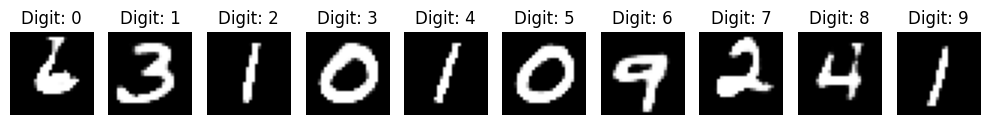

In [17]:
# Generate samples for each digit
all_samples = []
all_labels = []

for digit in range(10):
    labels = [digit]
    samples, _ = sample_diffusion()
    all_samples.append(samples)
    all_labels.extend(labels)
all_samples = torch.cat(all_samples, dim=0)

fig, axes = plt.subplots(1, 10, figsize=(10, 20))
for i, (sample, label) in enumerate(zip(all_samples, all_labels)):
    axes[i].imshow(sample.cpu().squeeze().numpy(), cmap="gray")
    axes[i].set_title(f"Digit: {label}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()